In [6]:
import os
import SimpleITK as sitk
import numpy as np
import pandas as pd 
import matplotlib.pylab as plt
from tqdm.notebook import trange, tqdm

In [50]:
DATA_PATH = "data/sample"
NODE_CSV_PATH = "data/sample/node.csv"

OUTPUT_PATH = "data/preprocessed"

SKIP_PREPROCESSED = False

In [3]:
def convert_to_voxel_coords(origin, spacing, coords):
    voxel_coords = [np.absolute(coords[i]-origin[i])/spacing[i] for i in range(len(coords))]
    return tuple(voxel_coords)

def create_coords_converter(origin, spacing):
    return lambda coords: convert_to_voxel_coords(origin, spacing, coords);

def get_coords_from_node_row(row):
    return row[["coordX", "coordY", "coordZ"]]

In [24]:
def load_scan(filename):
    scan_data = sitk.ReadImage(os.path.join(DATA_PATH, filename))
    origin = np.array(scan_data.GetOrigin())
    spacing = np.array(scan_data.GetSpacing())

    return sitk.GetArrayFromImage(scan_data), origin, spacing

In [4]:
def crop_subimage(slices, converter, coords, width = 50):
    x, y, z = converter(coords)
    return slices[int(z), int(y - width / 2):int(y + width / 2), int(x - width / 2):int(x + width / 2)]

In [5]:
def normalize_image(image):
    """From SITK - converting hounds units to grayscale units"""
    maxHU = 400.0
    minHU = -1000.0
    
    image = (image - minHU) / (maxHU - minHU)
    image[image > 1] = 1.0
    image[image < 0] = 0.0
    
    return (image * 255).astype(np.uint8);

In [57]:
def extract_features():
    skiped = 0
    errors = 0
    preprocessed = 0
    nodes = 0
    
    # create output dir
    if not os.path.exists(OUTPUT_PATH):
        os.makedirs(OUTPUT_PATH)
    
    # read csv data
    nodes_df = pd.read_csv(NODE_CSV_PATH)
    
    file_names = list(filter(lambda x: x.endswith(".mhd"), os.listdir(DATA_PATH)));
    for file_name in tqdm(file_names, desc="iterate over all mhd"):
        file_name_without_ext = file_name[:-4]
        # read all data which is connected with current file
        suspicious_places = nodes_df[nodes_df["seriesuid"] == file_name_without_ext]
        
        if len(suspicious_places) == 0:
            print("Cound't find csv data for {}".format(file_name));
            errors += 1
            continue
            
        path = os.path.join(OUTPUT_PATH, file_name_without_ext)
        if not os.path.exists(path):
            os.makedirs(path)
        elif SKIP_PREPROCESSED:
            skiped += 1
            continue
            
        # load scan data
        scan, origin, spacing = load_scan(file_name)
        
        # crate coords converter 
        converter = create_coords_converter(origin, spacing)
        
        preprocessed += 1
        for i, row in tqdm(suspicious_places.iterrows(), total=len(suspicious_places), desc="cut suspicious places"):
            coords = get_coords_from_node_row(row)
            subimage = crop_subimage(scan, converter, coords)
            subimage = normalize_image(subimage)
            nodes += 1
            np.save(os.path.join(path, "{}-{}.npy".format(i, row["class"])), subimage);

        return preprocessed, nodes, skiped, errors
preprocessed, nodes, skiped, errors = extract_features()
print ("Preprocessed: {}\nNodes {}\nSkiped: {}\nError: {}".format(preprocessed, nodes, skiped, errors))



Preprocessed: 1
Nodes 441
Skiped: 0
Error: 0


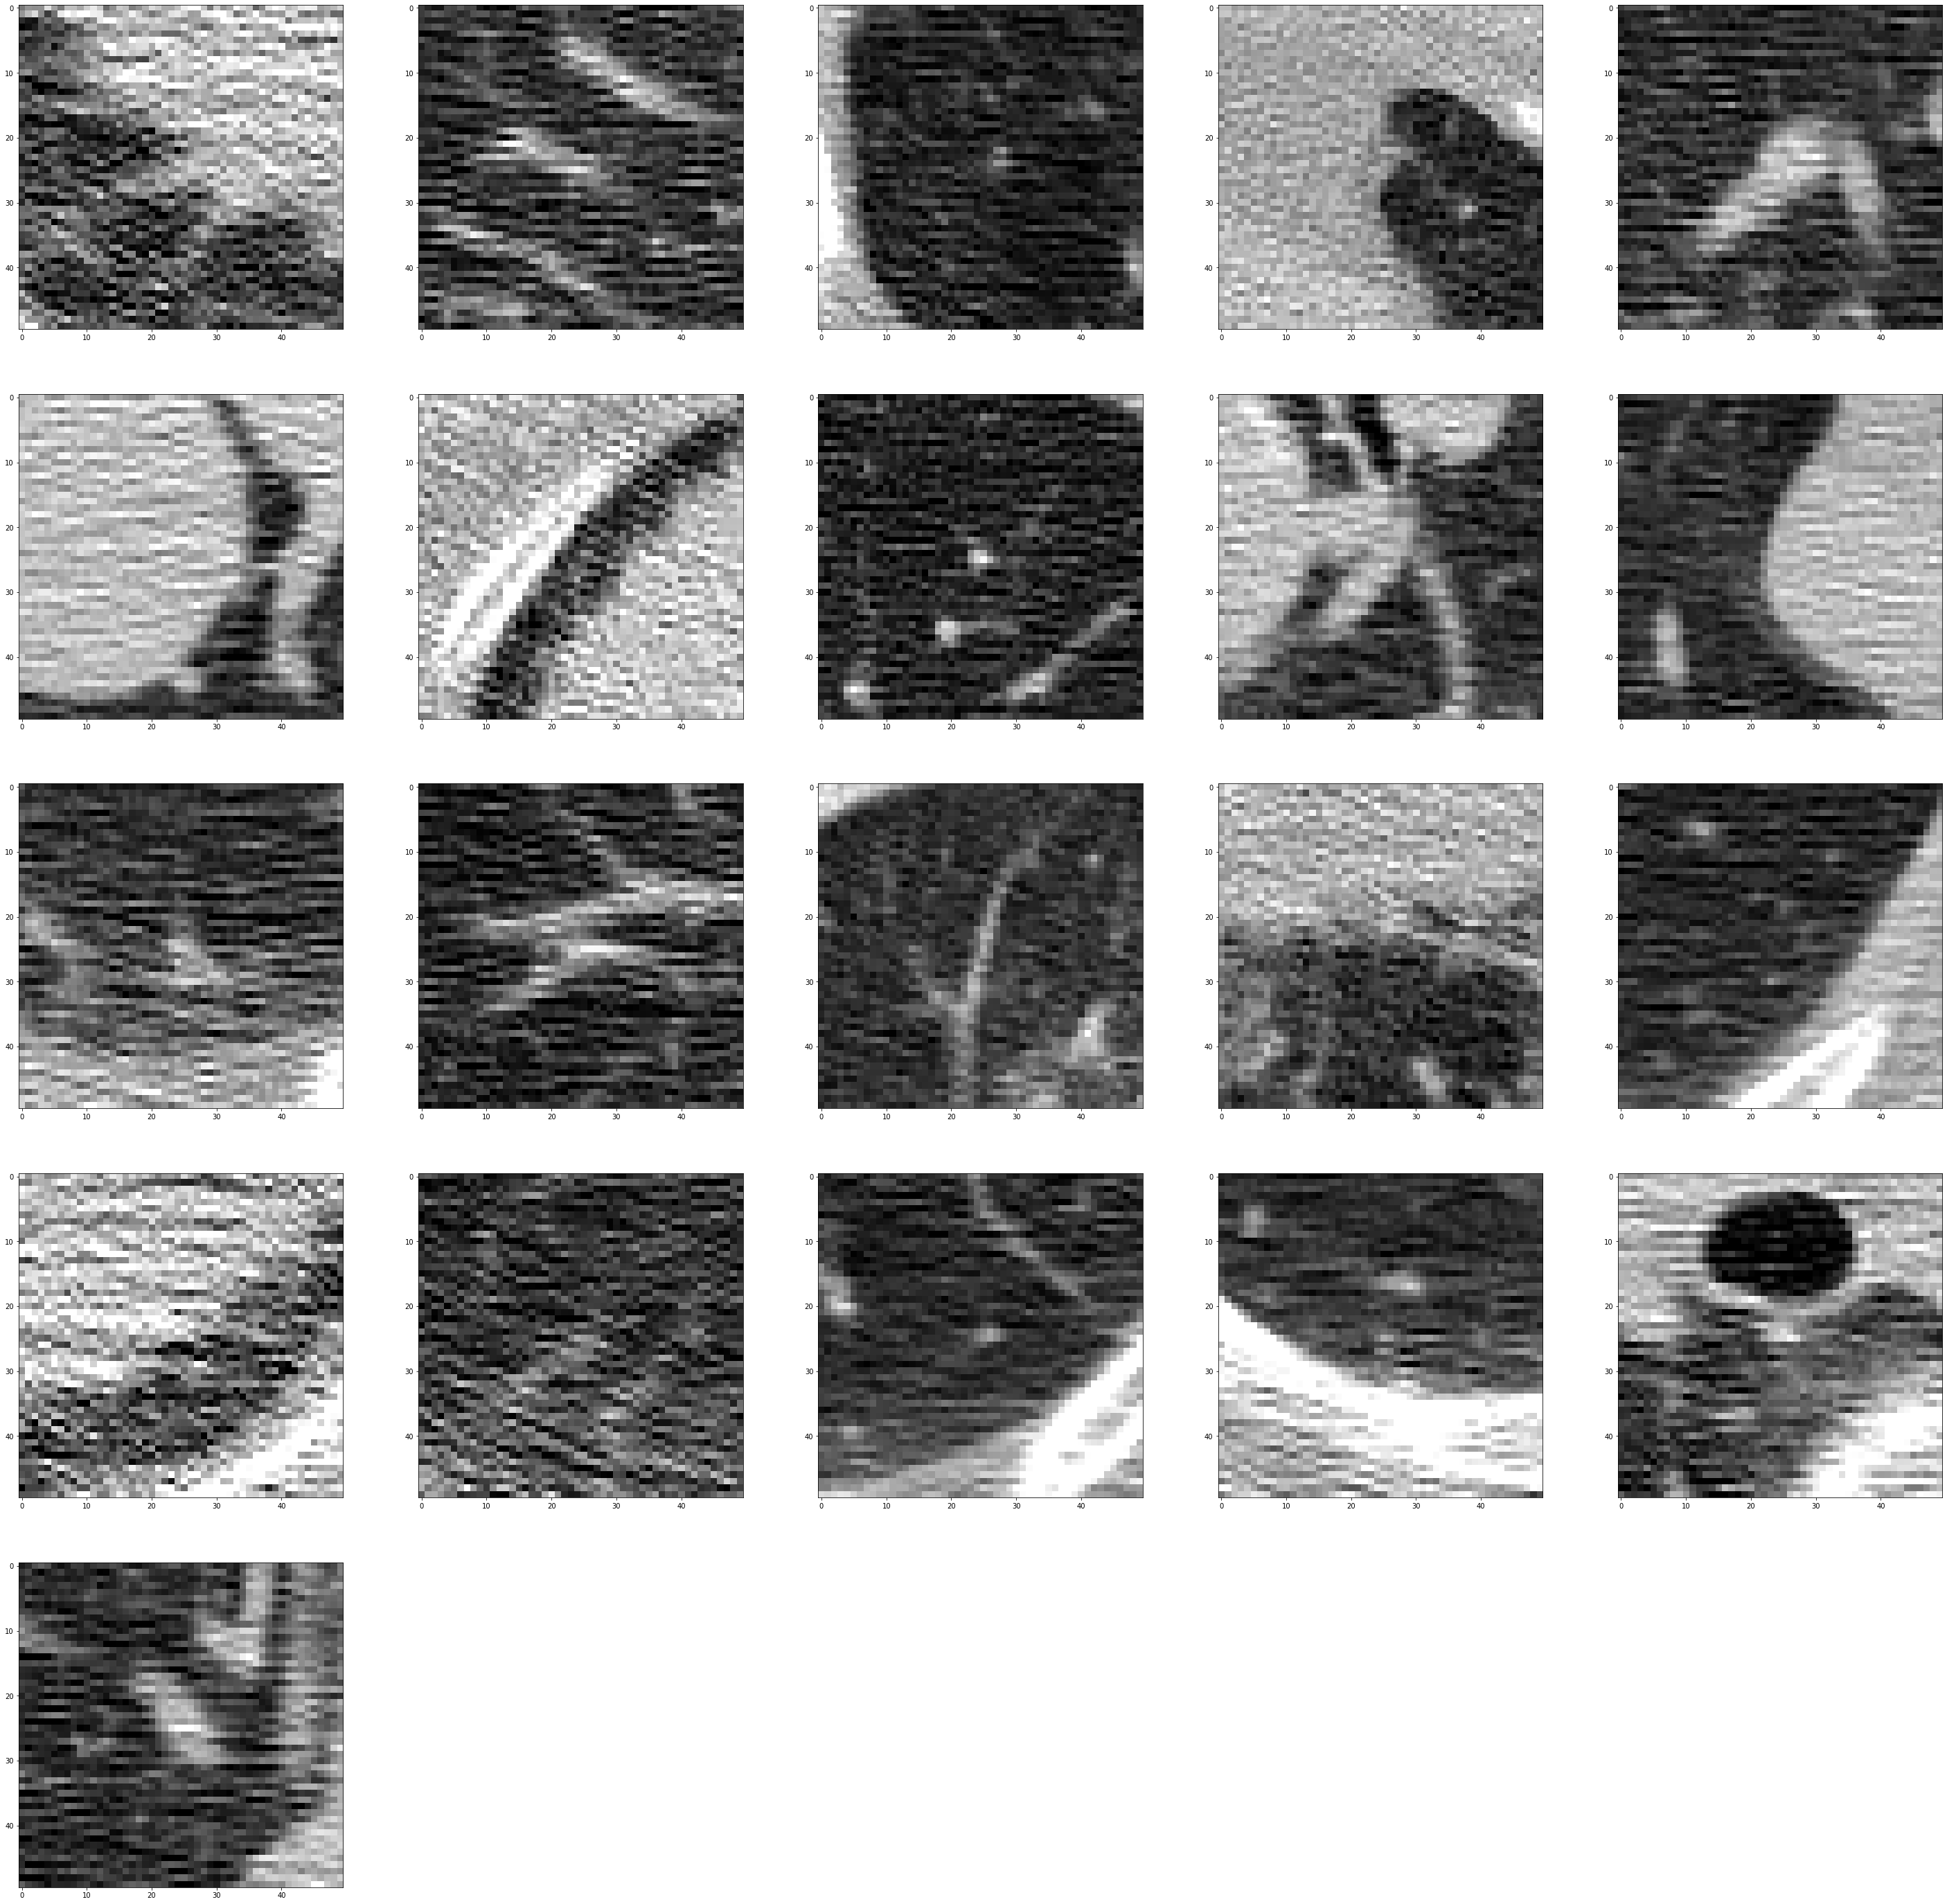

In [38]:
def test():
    file_names = os.listdir(OUTPUT_PATH)
    file_names = file_names[::int(len(file_names)/20)]
    
    fig = plt.figure(figsize=(50, 50))
    i = 0
    for name in file_names:
        image = np.load(os.path.join(OUTPUT_PATH, name))
        subplot = fig.add_subplot(len(file_names) / 5 + 1, 5, i + 1)
        i += 1
        subplot.imshow(image, cmap='gray')

test()